# Classification and clustering of Human Activity Recognition with Smartphones 

This dataset comes from the <a href=https://archive.ics.uci.edu/ml/>UCI Machine-Learning repository</a>. Please first read the <a href=https://archive.ics.uci.edu/ml/datasets/Smartphone+Dataset+for+Human+Activity+Recognition+%28HAR%29+in+Ambient+Assisted+Living+%28AAL%29>dataset description</a> to understand what is the data.


<b>The goal on this dataset is first to perform clustering on UNLABELLED data, and to learn a classifier on LABELLED. Finally, analysis should be conducted to check whether or not the clustering could be used for classification (i.e. does the clusters properly map on classes, possibly with more than 1 cluster per class?).</b>

Each example is a vector of dimension 561. And there are 7352 training examples, and 2947 testing examples.



### Importing the necessary packets

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')
import scipy


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



### Data loading and formatting

First, we work on pre-processed data, with 561 features extracted of each temporal series.

In [2]:
# Import the HAR dataset
x_train_file = open('train/X_train.txt', 'r')
y_train_file = open('train/y_train.txt', 'r')

x_test_file = open('test/X_test.txt', 'r')
y_test_file = open('test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# for the utilisation of binary classifier or neural network we also require the class encoded in forms of one-hot vectors  
from sklearn.preprocessing import LabelBinarizer
from subprocess import check_output
binarizer = LabelBinarizer().fit(y_train)
y_train_onehot = binarizer.transform(y_train)
y_test_onehot = binarizer.transform(y_test)

print( x_train.shape )
print( x_test.shape )



(7352, 561)
(2947, 561)


# 1- Supervised Classification

## 1- Random Forest Classifier

First, a Random Forest Classifier, with Cross-Validation on the three main parameters of this model: n_estimators, max_depth, and max_features.

A priori, the Random Forest Classifier appears adapted to our problem, which presents a high input dimension (561)

In [ ]:
param_grid = [
  {'n_estimators': [300, 400], 
   'max_depth':[5, 9],
   'max_features': ['sqrt', 'log2']}
 ]
#print(param_grid)

# Cross-validation grid-search
scores = ['precision', 'recall']
for score in scores:
    clf = GridSearchCV( RandomForestClassifier(n_estimators=150, criterion='entropy', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='sqrt', 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None), 
       param_grid, cv=3, scoring='%s_macro' % score)
    
    clf.fit(x_train, y_train_onehot)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    #print("Grid scores on development set:")
    #print()
    #means = clf.cv_results_['mean_test_score']
    #stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #   print("%0.3f (+/-%0.03f) for %r"
    #       % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_onehot, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()
    
    

Best parameters set found on development set:

{'max_depth': 9, 'max_features': 'log2', 'n_estimators': 400}


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.93      0.95      0.94       496
          1       0.92      0.84      0.88       471
          2       0.97      0.78      0.86       420
          3       0.99      0.78      0.88       491
          4       0.90      0.96      0.93       532
          5       1.00      1.00      1.00       537

avg / total       0.95      0.89      0.92      2947




Very good precision of 0.95: the Random Forest algorithm appeared particularly adapted to the big dimension and big number of classes.

In [9]:
#Now, let's work with integers -not one-hot encoded- to print the confusion matrix

y_pred_int = [len(np.where(r==1)[0]) for r in y_pred]

temp = [np.where(r==1)[0] for r in y_pred]

for k in range(y_pred.shape[0]):
    if(y_pred_int[k] == 1):
        y_pred_int[k] = temp[k][0]+1
    

print("\n CONFUSION MATRIX")
print( confusion_matrix(y_true, y_pred_int) )



 CONFUSION MATRIX
[[  0   0   0   0   0   0   0]
 [ 19 475   0   2   0   0   0]
 [ 47  14 404   6   0   0   0]
 [ 46  14  34 326   0   0   0]
 [ 46   0   0   0 382  63   0]
 [ 17   0   0   0   3 512   0]
 [  0   0   0   0   0   0 537]]


_We got some issues with our confusion matrix, du to the passage to one-hot encoded classes to normal classes... sorry for this issue_

Class 6 quite well identified. Confusions between classes 2 and 3, 1 and 2, and 5 and 4 -classes which are linked by nature (movements very close).

## 2- MLP Classifier

Then, we can test a Multi-Layer neural network classification, with a Cross-Validation on three key parameters, once again: the Hidden Layer Size, the Learning Rate, and the Alpha.

In [ ]:
param_grid = [
  {'hidden_layer_sizes': [(5,), (10,), (15,), (25,)], 
   'learning_rate_init':[0.003, 0.01, 0.03, 0.1],
   'alpha': [0.00001, 0.0001, 0.001, 0.01]}
 ]
#print(param_grid)

# Cross-validation grid-search
scores = ['precision', 'recall']
for score in scores:
    clf = GridSearchCV( MLPClassifier(activation='tanh', alpha=1e-07, batch_size=4, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.005, max_iter=500, momentum=0.8,
       nesterovs_momentum=True, power_t=0.5, random_state=11, shuffle=True,
       solver='adam', tol=1e-05, validation_fraction=0.3, verbose=False,
       warm_start=False), 
       param_grid, cv=3, scoring='%s_macro' % score)
    
    clf.fit(x_train, y_train_onehot)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    #print("Grid scores on development set:")
    #print()
    #means = clf.cv_results_['mean_test_score']
    #stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #    print("%0.3f (+/-%0.03f) for %r"
    #       % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_onehot, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

Best parameters set found on development set:

{'alpha': 0.0001, 'hidden_layer_sizes': (15,), 'learning_rate_init': 0.003}


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       496
          1       0.77      0.98      0.86       471
          2       1.00      0.68      0.81       420
          3       0.96      0.86      0.91       491
          4       0.88      0.96      0.92       532
          5       1.00      1.00      1.00       537

avg / total       0.93      0.92      0.92      2947




Accuracy a little bit less good than with Random Forest, but still quite corect.

In [10]:
#We 'desencode' the one-hot in order to print the confusion matrix

y_true, y_pred = y_test, clf.predict(x_test)
y_pred_int = [len(np.where(r==1)[0]) for r in y_pred]

temp = [np.where(r==1)[0] for r in y_pred]

for k in range(y_pred.shape[0]):
    if(y_pred_int[k] == 1):
        y_pred_int[k] = temp[k][0]+1
    

print("\n CONFUSION MATRIX")
print( confusion_matrix(y_true, y_pred_int) )



 CONFUSION MATRIX
[[  0   0   0   0   0   0   0]
 [ 15 477   1   3   0   0   0]
 [ 40  16 409   6   0   0   0]
 [ 48  15  33 324   0   0   0]
 [ 52   0   0   0 378  61   0]
 [ 17   0   0   0   6 509   0]
 [  2   0   0   0   0   0 535]]


_Once again, small issue with the confusion matrix..._

Most important confusions: between classes 3 and 2 (walking upstairs and downstaires), and between classes 4 and 5 (sitting and standing): that seems quit logical: movements close by nature. To note: the class 6 (laying) seems very well classified: because of its particular nature, far from the other movements, without any doubt.

## 3- SVM Classifier

An SVM implementation: but not very adapted to the big dimension (561) and the number of class (6)

(7352, 561)
(7352, 6)


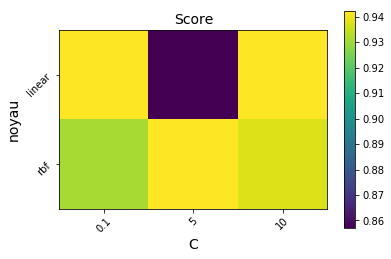

In [22]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 
              'C':[0.1, 5, 10]}

svc = svm.SVC(decision_function_shape='ovr')

clf = GridSearchCV(svc, parameters)

print(x_train.shape)
print(y_train_onehot.shape)
clf.fit(x_train, y_train)

plt.imshow(clf.cv_results_['mean_test_score'].reshape(len(parameters['kernel']), 
                                                      len(parameters['C'])), interpolation='none')

plt.xlabel('C', fontsize=14)
plt.ylabel('noyau', fontsize=14)
plt.title("Score", fontsize=14)

plt.xticks(np.arange(len(parameters['C'])), parameters['C'], rotation=45)
plt.yticks(np.arange(len(parameters['kernel'])), parameters['kernel'], rotation=45)

plt.colorbar()

## 4- MLP Classifier, in Tensorflow (Keras)

Now, a hand-made MLP, in Keras

In [7]:
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model

from keras.layers import Activation, Dense

from sklearn.model_selection import cross_val_score

In [8]:
#Creation of the Network Model

def build_model():
    model = Sequential()
     
    #Simple but efficient Neural Network with dropouts after each Network Layer to limit Over Fitting (a L1, or L2 regularizer could also be used to prevent over fitting)
    
    model.add(Dense(561, input_dim=561, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(64, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(6, activation='softmax'))
    model.summary()
    return model

We create, by hand, a very simple neural network, with one hidden layer of 64 neurons.

In [14]:
#Building of the model

model = build_model()

#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''

estimator = model

#Adam seems to be a very good Optimizer, and the MSE loss is adapted to Regression Tasks
estimator.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

#A Simple Early Stop callback to avoid over fitting: when the loss of the validation set increases during a certain number of epochs, the training of the Network stops
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=(20))

# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 40

#Training of the Network, with an independant validation set
history = estimator.fit(x_train, y_train_onehot, verbose = 0, epochs=EPOCHS, validation_split=0.1, batch_size=32, callbacks=[early_stop, PrintDot()])

test_loss, test_acc = model.evaluate(x_test, y_test_onehot)

print('Test accuracy:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 561)               315282    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                35968     
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 351,640
Trainable params: 351,640
Non-trainable params: 0
_________________________________________________________________

2947/2947 [==============================] - 0s 45us/step
Test accuracy: 0.9463861554122837


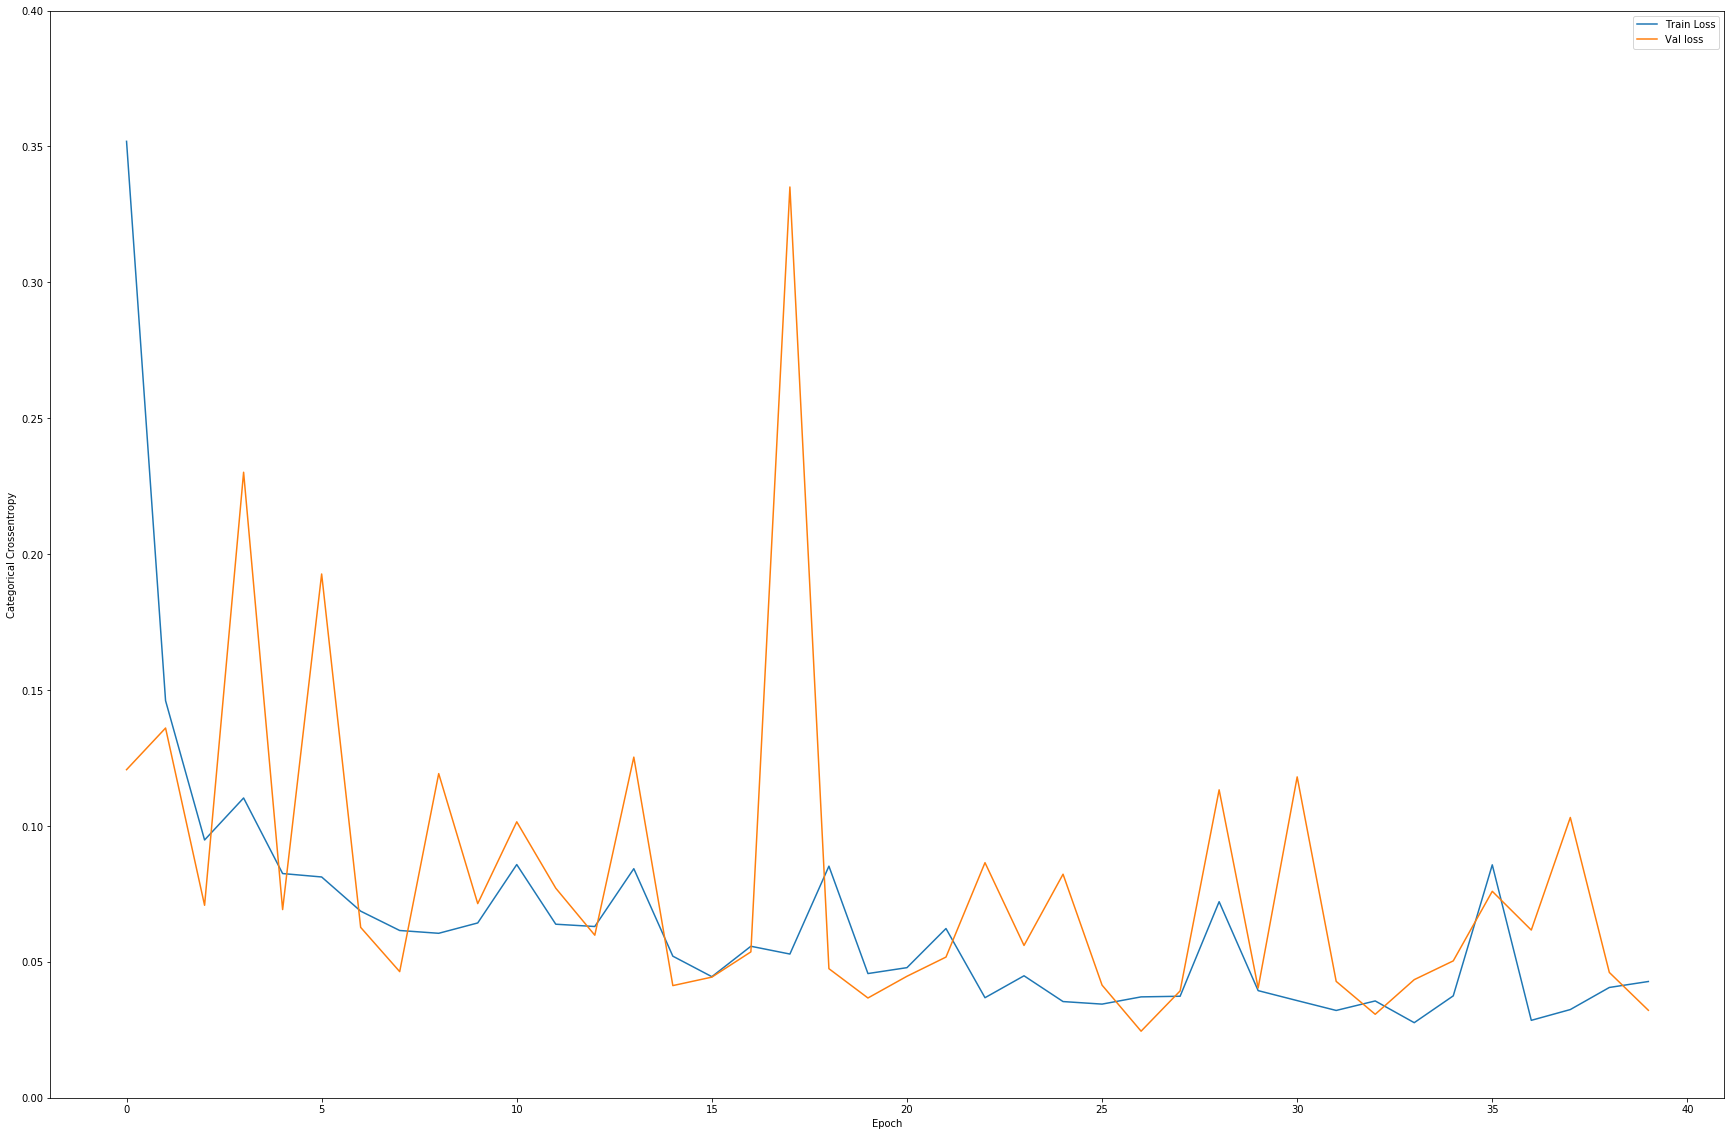

In [11]:
def plot_history(history):
  plt.figure(figsize = (30, 20))
  plt.xlabel('Epoch')
  plt.ylabel('Categorical Crossentropy')
  plt.plot(history.epoch, np.array(history.history['loss']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,0.4])
  plt.savefig('loss_evolution.png')

plot_history(history)

What is very interesting here is that we quickly have very high accuracy on the validation set: of the order of 0.98. But we never get such an accuracy on the testing set.
Why ?
It may be linked to the fact that the testing set is recorded on different people than the training set: those different people may have, essentially, different movements than those from the training set, and, consequently, it is possible that we never manage to obtain very high accuracy on the testing set.
The training set should maybe have been recorded on more different people.

# 2- The Clustering Analysis

## 1- K-Means Clustering

First, a K-Means algorithm.

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=24, init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, 
                algorithm='auto').fit(x_train)



We choose a ratio of 4 clusters per class (i.e. 24 clusters) in order to have a good homogeneity of class in each cluster.
We study this homogeneity with the code below:

In [17]:
x = kmeans.labels_
number_clusters = len(set(x))
number_classes = 6
total_prob = 0
total_ent = 0
nb_int = 0
p = 0

class_clusters = [0 for x in range(number_clusters)] #link between clusters and majority class
av_class = [[0 for x in range(number_classes)] for y in range(2)] #averrage proba for each class, counted only when it is a majority class

for i in range(0, number_clusters):
    print("Cluster", i, ":")
    place = np.where(x == i)[0]
    length = len(y_train[place].tolist())
    max = 0

    for j in range(1, number_classes+1):
        p = y_train[place].tolist().count(j) / length
        #if(p>0.3):
        #    print("Proportion of class", j, "in cluster", i, ":", p)   
        if(p>max):
            max = p
            max_ind = j
    if(max > 0.8):
        nb_int += 1
    print("Major class:", max_ind, ", proba: ", max)
    entropy = scipy.stats.entropy(np.bincount(y_train[place].tolist()),base=3)
    print("Entropy:", entropy)
    total_prob += max
    total_ent += entropy
    class_clusters[i] = max_ind
    av_class[0][max_ind - 1] += max
    av_class[1][max_ind - 1] += 1
    
for i in range(number_classes):
    av_class[0][i] = av_class[0][i]/av_class[1][i]
    
av_class_final = av_class[0]

print()
print("Mean proba for the majority class:", total_prob/number_clusters)
print("Number of well-fitted clusters:", nb_int)
print("Mean entropy:", total_ent/number_clusters)

Cluster 0 :
Major class: 5 , proba:  0.5645161290322581
Entropy: 0.6233311520256136
Cluster 1 :
Major class: 3 , proba:  0.8246753246753247
Entropy: 0.49902870989336257
Cluster 2 :
Major class: 2 , proba:  0.625
Entropy: 0.742680472227775
Cluster 3 :
Major class: 6 , proba:  0.9656862745098039
Entropy: 0.136018177132184
Cluster 4 :
Major class: 6 , proba:  0.9728353140916808
Entropy: 0.11354668263330067
Cluster 5 :
Major class: 1 , proba:  0.9875
Entropy: 0.06629171749190967
Cluster 6 :
Major class: 4 , proba:  0.5322812051649928
Entropy: 0.6290313561550702
Cluster 7 :
Major class: 2 , proba:  0.8716417910447761
Entropy: 0.4087934331200282
Cluster 8 :
Major class: 1 , proba:  0.9642857142857143
Entropy: 0.14024611344719423
Cluster 9 :
Major class: 4 , proba:  0.8470873786407767
Entropy: 0.3893350145204116
Cluster 10 :
Major class: 1 , proba:  0.876010781671159
Entropy: 0.4189576346084081
Cluster 11 :
Major class: 2 , proba:  1.0
Entropy: 0.0
Cluster 12 :
Major class: 6 , proba:  0.9778

To study the accuracy of our clustering, we analyse different properties: the global entropy of our clusters (the closer to zero, the best it is ; on the contrary, an entropy of 1 represents a random repartition of the classes in the cluster), and the mean probability of the best class of each cluster: the higher it is, the better our clusters are, globally, linked to a single class (this is what we want).

For clusters with high entropy, we can study the second most important class, and we will see that it is often a class essentially linked, by nature, to the most important class.
For instance: in some clusters with high entropy, clusters 2 and 3 share an important part of probability ; this is because they are linked by nature: they correspond to "Walking Upstairs" and "Walking Downstairs".

In [17]:
index_sorted = sorted(range(len(av_class_final)), key=lambda k: av_class_final[k], reverse = True)
av_class_final_sorted = sorted(av_class_final, reverse = True)
print("The classes that have been the best learnt by the clustering are, in order:")

for i in range(number_classes):
    print("Class", index_sorted[i]+1, "with averrage proba:", av_class_final_sorted[i])

The classes that have been the best learnt by the clustering are, in order:
Class 6 with averrage proba: 0.9866979756461257
Class 1 with averrage proba: 0.9010481787379356
Class 3 with averrage proba: 0.8378960915075688
Class 4 with averrage proba: 0.7643705369471733
Class 2 with averrage proba: 0.7363838465812409
Class 5 with averrage proba: 0.703214102904315


We see that the class 6 seems to be the best classified by K-Means (clusters linked to the class 6 are very homogeneous).
Once again, this result is linked to the fact that the class 6: Laying, is very different from the other classes, by nature.

## 2- Agglomerative Clustering

Now, some agglomerative algorithms: Ward, Complete, Average or Single Linkage

First, just to show that we have to take a high number of cluster to have a good class-cluster representation, let's test with only 6 clusters (the number of classes), to see the result.

In [19]:
from sklearn.cluster import AgglomerativeClustering

#to test, for the linkage: ward, complete, average, single

clustering = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=6,
            pooling_func='deprecated').fit(x_train)



In [20]:
x = clustering.labels_
number_clusters = len(set(x))
number_classes = 6
total_prob = 0
total_ent = 0
nb_int = 0
p = 0

for i in range(0, number_clusters):
    print("Cluster", i, ":") 
    place = np.where(x == i)[0]
    length = len(y_train[place].tolist())
    max = 0
    
    for j in range(1, number_classes+1):
        p = y_train[place].tolist().count(j) / length     
        if(p>max):
            max = p
            max_ind = j
    
    if(max > 0.8):
        nb_int += 1
    print("Major class:", max_ind, ", proba: ", max)
    entropy = scipy.stats.entropy(np.bincount(y_train[place].tolist()),base=3)
    print("Entropy:", entropy)
    total_prob += max
    total_ent += entropy
print()
print("Mean proba for the majority class:", total_prob/number_clusters)
print("Number of well-fitted clusters:", nb_int)
print("Mean entropy:", total_ent/number_clusters)

Cluster 0 :
Major class: 6 , proba:  0.9943302622253721
Entropy: 0.03184106957913613
Cluster 1 :
Major class: 2 , proba:  0.5210656753407683
Entropy: 0.7561369117891582
Cluster 2 :
Major class: 3 , proba:  0.5041265474552957
Entropy: 0.9144454657600422
Cluster 3 :
Major class: 5 , proba:  0.5748953974895398
Entropy: 0.6206795725077149
Cluster 4 :
Major class: 4 , proba:  0.5267123287671233
Entropy: 0.6449644130600382
Cluster 5 :
Major class: 3 , proba:  0.8761467889908257
Entropy: 0.3409142505962755

Mean proba for the majority class: 0.6662128333781542
Number of well-fitted clusters: 2
Mean entropy: 0.5514969472153942


Very poor results (except for the class 6, as usual) !

Now, we could try with much more clusters. Let's say, 4 clusters for one class: 24 clusters.

In [14]:

#to test, for the linkage: ward, complete, average, single

clustering = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=24,
            pooling_func='deprecated').fit(x_train)



In [15]:
x = clustering.labels_
number_clusters = len(set(x))
number_classes = 6
total_prob = 0
total_ent = 0
nb_int = 0
p = 0

class_clusters = [0 for x in range(number_clusters)] #link between clusters and majority class
av_class = [[0 for x in range(number_classes)] for y in range(2)] #averrage proba for each class, counted only when it is a majority class

for i in range(0, number_clusters):
    print("Cluster", i, ":") 
    place = np.where(x == i)[0]
    length = len(y_train[place].tolist())
    max = 0
    
    for j in range(1, number_classes+1):
        p = y_train[place].tolist().count(j) / length 
        #if(p>0.3):
        #    print("Proportion of class", j, "in cluster", i, ":", p)      
        if(p>max):
            max = p
            max_ind = j
    
    if(max > 0.8):
        nb_int += 1
    print("Major class:", max_ind, ", proba: ", max)
    entropy = scipy.stats.entropy(np.bincount(y_train[place].tolist()),base=3)
    print("Entropy:", entropy)
    total_prob += max
    total_ent += entropy
    class_clusters[i] = max_ind
    av_class[0][max_ind - 1] += max
    av_class[1][max_ind - 1] += 1
    
for i in range(number_classes):
    av_class[0][i] = av_class[0][i]/av_class[1][i]
    
av_class_final = av_class[0]

print()
print("Mean proba for the majority class:", total_prob/number_clusters)
print("Number of well-fitted clusters:", nb_int)
print("Mean entropy:", total_ent/number_clusters)

Cluster 0 :
Major class: 6 , proba:  0.9879310344827587
Entropy: 0.05944397830764359
Cluster 1 :
Major class: 2 , proba:  0.5882352941176471
Entropy: 0.616681982749401
Cluster 2 :
Major class: 5 , proba:  0.6304985337243402
Entropy: 0.5995653118375215
Cluster 3 :
Major class: 2 , proba:  0.9967213114754099
Entropy: 0.020051139558306293
Cluster 4 :
Major class: 5 , proba:  0.6444121915820029
Entropy: 0.5924175992944953
Cluster 5 :
Major class: 4 , proba:  0.7323775388291517
Entropy: 0.5505607558014115
Cluster 6 :
Major class: 6 , proba:  1.0
Entropy: 0.0
Cluster 7 :
Major class: 3 , proba:  1.0
Entropy: 0.0
Cluster 8 :
Major class: 1 , proba:  0.6947368421052632
Entropy: 0.5600319915702127
Cluster 9 :
Major class: 2 , proba:  0.39114391143911437
Entropy: 0.9760392407775293
Cluster 10 :
Major class: 3 , proba:  1.0
Entropy: 0.0
Cluster 11 :
Major class: 1 , proba:  1.0
Entropy: 0.0
Cluster 12 :
Major class: 2 , proba:  0.9415204678362573
Entropy: 0.22007212663097983
Cluster 13 :
Major cl

#### The more there are clusters, the better is the Mean proba for the majority class, and the smaller is the Mean Entropy. Logical.

We seem to have a better clustering than with the previous k-means: smaller mean entropy per cluster, and better mean proba for the majority class.
This result is quite encouraging, we're going to be able to be able to build a classifier on those clusters, and see what accuracy we can have from those "noisy" labels.

Some further analysis:

In [7]:
index_sorted = sorted(range(len(av_class_final)), key=lambda k: av_class_final[k], reverse = True)
av_class_final_sorted = sorted(av_class_final, reverse = True)
print("The classes that have been the best learnt by the clustering are, in order:")

for i in range(number_classes):
    print("Class", index_sorted[i]+1, "with averrage proba in their clusters:", av_class_final_sorted[i])

The classes that have been the best learnt by the clustering are, in order:
Class 6 with averrage proba in their clusters: 0.9963788938863901
Class 3 with averrage proba in their clusters: 0.9507082645346312
Class 1 with averrage proba in their clusters: 0.9154712291439043
Class 2 with averrage proba in their clusters: 0.7835241969736858
Class 4 with averrage proba in their clusters: 0.7813402845660911
Class 5 with averrage proba in their clusters: 0.6748364803990646


The results are way better than with K-Means, but they reflet the same ideas: the classes 4 and 5 (sitting and stading, which are quite mixed in their clusters) are very poorly clustered, compared to the classes 6 and 3 (laying and walking downstairs). The class 6 is always the best fitted by the clusters, because of its particular nature, as always.

## 3- Let's test classification on those clusters: 

We try to classify our testing set (with its true classes) from our clusters, which are globally well corellated to our classes.

The more clusters we define (thanks to our agglomerative method), the more this classification will be accurate: the more our clusters globally fit their majority class.

In [26]:
from sklearn.ensemble import RandomForestClassifier

y_train = clustering.labels_
# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=400, criterion='gini', max_depth=9,
                             min_samples_split=2, min_samples_leaf=1, 
              
                             min_weight_fraction_leaf=0.0, max_features='log2', 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(x_train, y_train)
print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)

# Evaluate acuracy on test data
prediction = clf.predict(x_test)
for j in range(len(prediction)):
    prediction[j] = class_clusters[prediction[j]]
    
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print( classification_report(y_test, prediction) )
print("\n CONFUSION MATRIX")
print( confusion_matrix(y_test, prediction) )


n_estimators= 400  max_depth= 9 max_features= log2
             precision    recall  f1-score   support

          1       0.83      0.86      0.85       496
          2       0.79      0.94      0.86       471
          3       0.95      0.70      0.81       420
          4       0.89      0.52      0.66       491
          5       0.68      0.94      0.79       532
          6       1.00      1.00      1.00       537

avg / total       0.86      0.84      0.83      2947


 CONFUSION MATRIX
[[429  58   9   0   0   0]
 [ 21 444   6   0   0   0]
 [ 64  60 296   0   0   0]
 [  0   0   0 257 234   0]
 [  0   0   0  33 499   0]
 [  0   0   0   0   0 537]]


#### Accuracy of 0.86. Not bad results for "noisy" labels !

## 4- Now, let's try to classify the ids of the clusters themselves

We take a part of our training set to do this: because the clustering has be done on this training set, it would be a non-sens to study the link between this clustering and a new clustering, on the testing set.

In [27]:
ratio = 8/10

cut = int(y_train.shape[0]*ratio)
x1 = x_train[:cut]
x2 = x_train[cut:]
y1 = y_train[:cut]
y2 = y_train[cut:]

In [28]:
# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=400, criterion='gini', max_depth=9,
                             min_samples_split=2, min_samples_leaf=1, 
              
                             min_weight_fraction_leaf=0.0, max_features='log2', 
                             max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(x1, y1)
print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)

# Evaluate acuracy on test data
score = clf.score(x2, y2)
print("Acuracy (on test set) = ", score)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_true, y_pred = y2, clf.predict(x2)
print( classification_report(y_true, y_pred) )
print("\n CONFUSION MATRIX")
print( confusion_matrix(y_true, y_pred) )

n_estimators= 400  max_depth= 9 max_features= log2
Acuracy (on test set) =  0.7627464309993202
             precision    recall  f1-score   support

          0       0.84      0.68      0.75       149
          1       0.00      0.00      0.00         0
          2       0.79      0.82      0.81        68
          3       0.99      0.98      0.99       114
          4       0.72      0.86      0.78       138
          5       0.87      0.86      0.86       193
          6       0.88      0.75      0.81        20
          7       0.00      0.00      0.00         0
          9       0.59      0.29      0.39        76
         10       0.90      0.50      0.64       124
         11       0.00      0.00      0.00         0
         12       0.77      0.99      0.87       102
         13       0.51      0.94      0.66        52
         14       0.63      0.59      0.61       110
         15       0.68      0.90      0.78       112
         16       0.95      0.64      0.77        28
   

What is interesting is: the more important the number of clusters is, the less accurate the classification is. This seems logical (because the clustering is more and more abstract), but it is an inverse result from the previous classification study, based on the class nature.
Moreover, the precision of the classification of the 24 clusters themselves is less accurate than the "noisy" classification on the classes through the clusters ! Kind of logical: the clustering information is kind of "smoothed" when looked through the majority class aspect.

### Finally, some things we could have used to determine a good number of clusters, but not quite appropriate in this case.

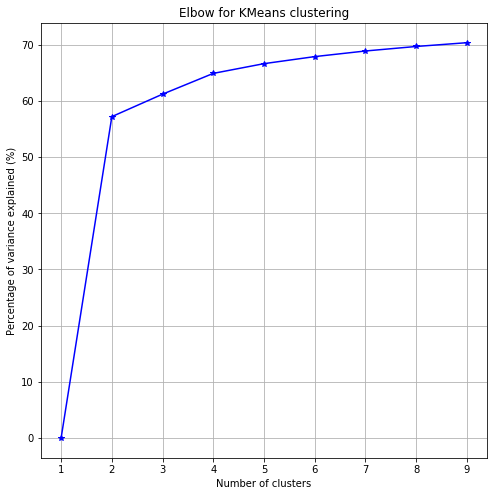

In [29]:
from scipy.spatial.distance import cdist, pdist

Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(x_train) for i in Ks]

def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, x_train)

We see a "break" in the curve of variance explained for 2 clusters: this fact is also reflected by our SOM Map: our classes are essentially divided in two big clusters: classes 1, 2 and 3 in one cluster (the "walking" cluster), and classes 4, 5 and 6 in another one (the sitting, standing and laying cluster).

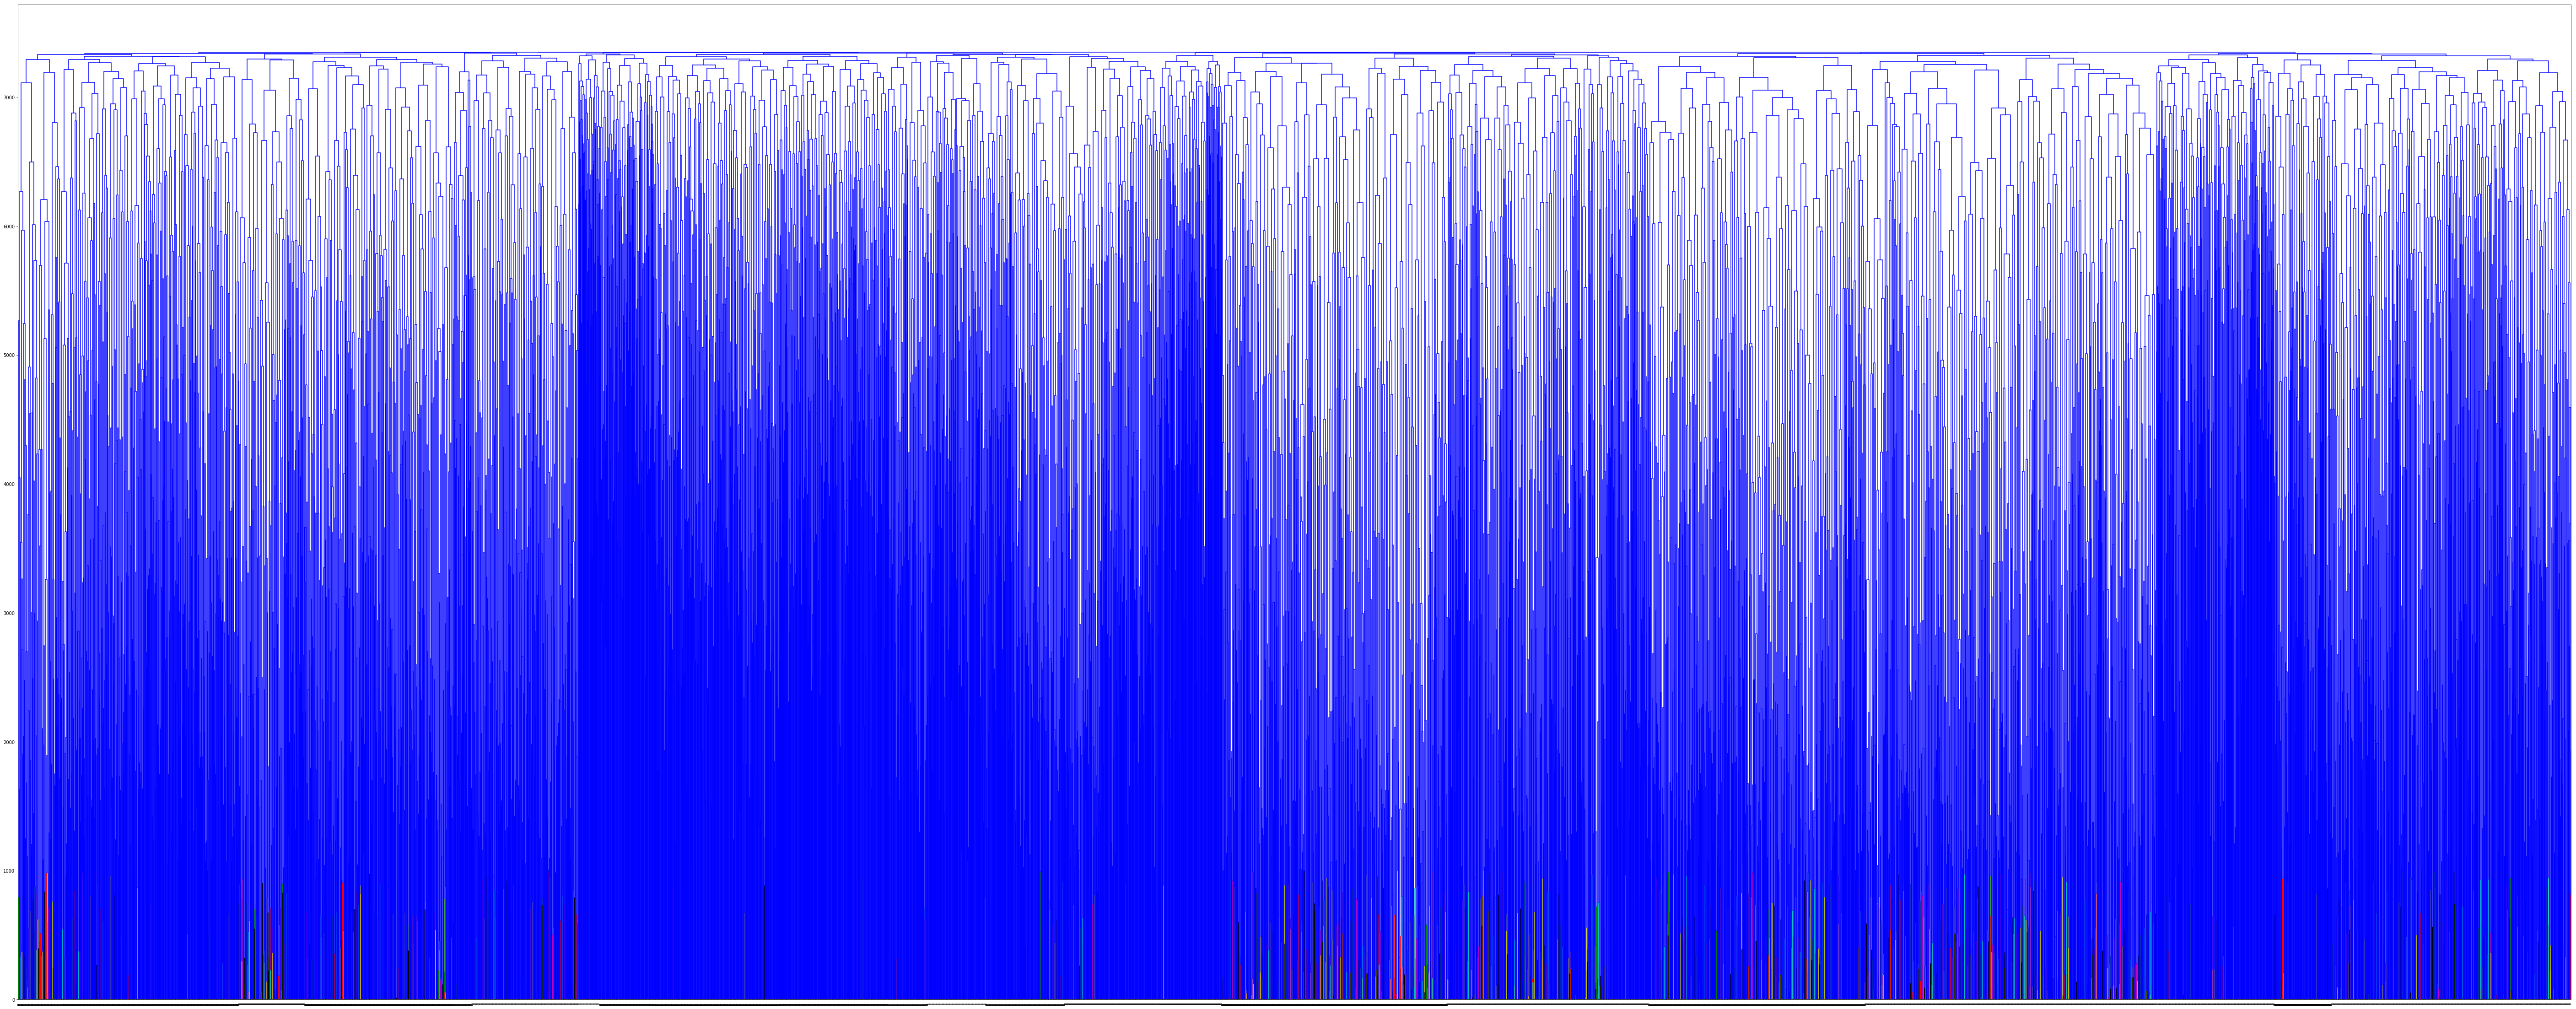

In [30]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

def plot_dendrogram(model, **kwargs):
     # Children of hierarchical clustering
    children = model.children_
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
     # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

fig = plt.figure(figsize=(100,40))

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=1000)
plt.axhline(y=6, c='grey', lw=1, linestyle='dashed')
plt.show()


(Dendrogram not seems adapted in this case (too many examples), should maybe consider the evolution of the distance between each  pair of clusters merged, and consider the first gap on the curve as a good number of clusters to consider (it is in fact a kind of other representation of Dendrogram). We would probably find the number of 2 clusters as essential, as seen before, and as expressed by the Self Organizing Map.)

### A bit of Spectral Clustering (but maybe not that adapted to as many classes as 6 classes):

In [ ]:
from sklearn.cluster import SpectralClustering

sp_clustering = SpectralClustering(n_clusters=12, eigen_solver=None, random_state=None, n_init=10, gamma=1.0, 
                   affinity='rbf', n_neighbors=10, eigen_tol=0.0, 
                   assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None).fit(x_train)

sp_clustering.labels_

_This process takes way too much time to train, not adapted to our problems: too many clusters._

## 5- Self Organizing Map (Kohonen Network):

##### We're going to implement a small SOM, largely based on [this](http://www.ai-junkie.com/ann/som/som1.html) article.

In [3]:
def group_targets_per_bmu(dataset, target, indices,som):
    '''
        Returns a som-shaped array.
        At coordinates (y,x) are stocked all the targets
        of the data for which (y,x) is the BMU in the som.
        dataset: a sk learn dataset.
        indices: indices of the data we're interested in the dataset.
        som: a SOM object, trained on this data.
    '''
    groups = [[[] for x in range(som.shape[1])] for y in range(som.shape[0])]
    for i in indices:
        bmu = som.find_bmu(dataset[i])
        groups[bmu[0]][bmu[1]].append(target[i])
    return groups
def majority(l):
    '''
        Returns the most frequent element of an array.
        -1 if the array is empty.
        l: list of integers.
    '''
    if len(l) == 0:
        return -1
    return np.argmax(np.bincount(l))
def get_majority_matrix(targets_per_bmu):
    '''
        Returns the np matrix of majority elements
        in targets_per_bmu.
        targets_per_bmu: array returned by `group_targets_per_bmu`.
    '''
    maj_mat = np.zeros((len(targets_per_bmu),len(targets_per_bmu[0]))).astype(int)
    for y in range(len(targets_per_bmu)):
        for x in range(len(targets_per_bmu[0])):
            maj_mat[y,x] = majority(targets_per_bmu[y][x])
    return maj_mat

def get_entropy_matrix(targets_per_bmu):
    '''
        Returns the np matrix of entropies in
        targets_per_bmu's distributions.
        targets_per_bmu: array returned by `group_targets_per_bmu`.
    '''
    entropy_mat = np.zeros((len(targets_per_bmu),len(targets_per_bmu[0])))
    for y in range(entropy_mat.shape[0]):
        for x in range(entropy_mat.shape[1]):
            entropy_mat[y,x] = scipy.stats.entropy(np.bincount(targets_per_bmu[y][x]),base=3)
    return entropy_mat

In [4]:
from matplotlib import colors

# Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)

In [5]:
from som import *

som = SOM(20,20,561)
som.train(x_train,L0=0.8,lam=1e2,sigma0=5)


final t: 231


In [6]:
indices_train = list(range(1,x_train.shape[0]))
#indices_train = np.random.choice(range(7352),int(1000),replace=False)
targets_per_bmu = group_targets_per_bmu(x_train,y_train,indices_train,som)
maj_mat = get_majority_matrix(targets_per_bmu)


#### Majoritary Class Map

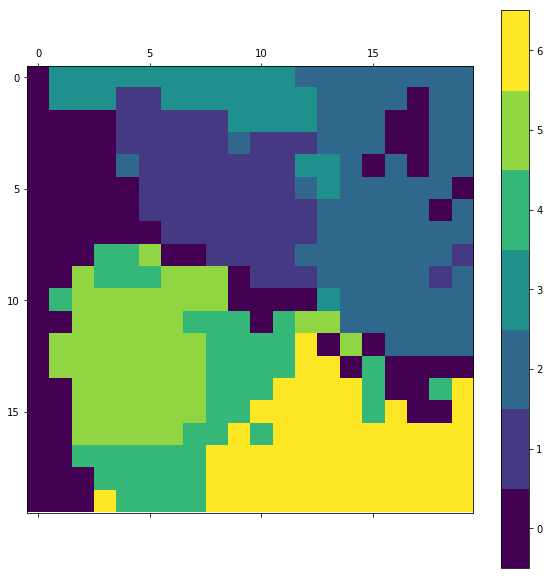

In [7]:
plt.figure(figsize=(10,10))
img = plt.matshow(maj_mat,cmap=discrete_cmap(7), fignum=1)
plt.colorbar(ticks=[range(7)])
plt.clim(-0.5, 7 - 0.5)
plt.show()

#### What is very nice here is the visual representations of our clustered classes: a clear line of separation between the classes 4, 5 and 6 (sitting, standing, laying), and the classes 1, 2 and 3 (Walking, Walking Upstairs, Walking Downstairs).
Very logical, and already seen in the previous clustering methods analysis (kmeans et agglomerative, and thanks to the Elbow graph), but quite nice to look at.

#### Entropy map

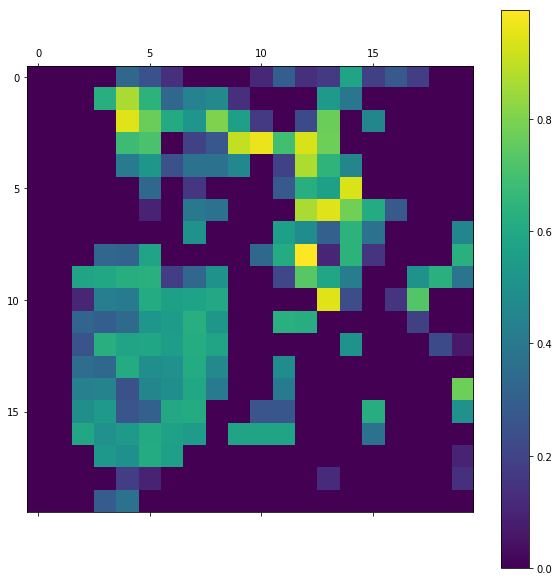

Mean entropy: 0.20496496894293542


In [8]:
import scipy.stats

matfig = plt.figure(figsize=(10,10))
entropy_mat = get_entropy_matrix(targets_per_bmu)
img = plt.matshow(entropy_mat, fignum=matfig.number)
plt.colorbar(img)
plt.show()

print("Mean entropy:", entropy_mat.mean())

As with other clusterings methods, the class 3: Walking Upstairs, and 6: Laying, appear to be the best "learnt" by the clusters.
The entropy is particularly high on the borders of the clusters, which is normal.

#### Classification thanks to SOM ?

We're going to use our trained SOM to classifiy new input: simply by affecting each input vector to its nearest BMU, and then by taking the majoritary class of this BMU.

In [9]:
good_answers = 0
mean_entropy = 0.0

indices_test = list(range(x_test.shape[0]))

y_pred = [0 for j in indices_test]

for i in indices_test:
    input_vec = x_test[i]
    target = y_test[i]
    
    bmu = som.find_bmu(input_vec)
    prediction = maj_mat[bmu]
    mean_entropy += entropy_mat[bmu]
    good_answers += (prediction == target)
    
    y_pred[i] = prediction

good_answers /= len(indices_test)
mean_entropy /= len(indices_test)
print("Accuracy:",good_answers)
print("Mean entropy:",mean_entropy)


print( classification_report(y_test, y_pred) )
print("\n CONFUSION MATRIX")
print( confusion_matrix(y_test, y_pred) )


Accuracy: 0.7994570749915167
Mean entropy: 0.3223203240431617
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          1       0.70      0.95      0.81       496
          2       0.83      0.79      0.81       471
          3       0.93      0.57      0.71       420
          4       0.74      0.66      0.70       491
          5       0.73      0.81      0.77       532
          6       0.99      0.96      0.98       537

avg / total       0.82      0.80      0.80      2947


 CONFUSION MATRIX
[[  0   0   0   0   0   0   0]
 [  0 469  14  13   0   0   0]
 [ 15  78 373   5   0   0   0]
 [  0 121  59 240   0   0   0]
 [  1   0   2   0 326 157   5]
 [  4   0   0   0  97 430   1]
 [  3   0   0   0  16   0 518]]


#### This simple method works quite nicely (not far from agglomerative clustering + random forest !), and fun to implement.

### Having some fun with a Vorodoi representation, just for aesthetics

In [10]:
bmu_locations_x, bmu_locations_y = [],[]
colors_c = []
c_to_use = ['red','yellow', 'orange', 'cyan','blue', 'purple']
for i in indices_train:
    data_p = x_train[i]
    bmu = som.find_bmu(data_p)
    bmu_locations_x.append(bmu[1])
    bmu_locations_y.append(bmu[0])
    colors_c.append(c_to_use[maj_mat[bmu] - 1])

In [11]:
def is_valid_unit(som,unit):
    y,x = unit
    return y >= 0 and y < som.shape[0] and x >= 0 and x < som.shape[1]
def one_adj_mean_dist(som,unit):
    y,x = unit
    dirs = [[0,1],[1,0],[0,-1],[-1,0]]
    dists = []
    for dir_ in dirs:
        y_n,x_n = y+dir_[0],x+dir_[0]
        if is_valid_unit(som,(y_n,x_n)):
            dists.append(np.linalg.norm(som.som[unit]-som.som[(y_n,x_n)]))
    return np.array(dists).sum()
def get_one_adj_U_mat(som):
    U_mat = np.zeros(som.shape[:2])
    for y in range(som.shape[0]):
        for x in range(som.shape[1]):
            U_mat[(y,x)] = one_adj_mean_dist(som,(y,x))
    return U_mat

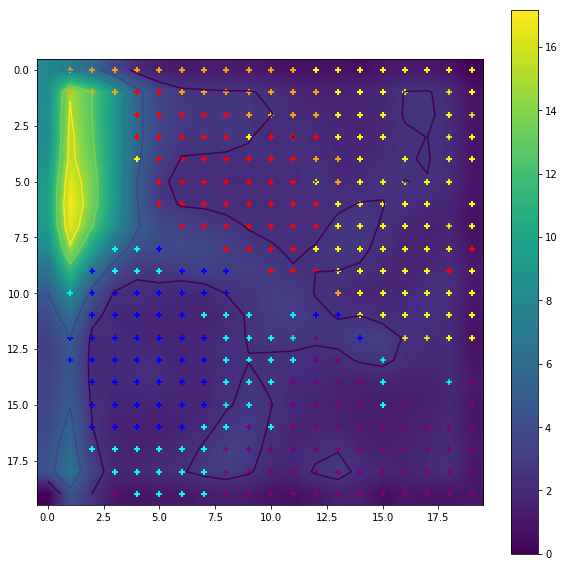

In [12]:
from scipy.spatial import Voronoi, voronoi_plot_2d

points = np.array(list(zip(bmu_locations_x,bmu_locations_y)))

vor = Voronoi(points)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
one_adj_U_mat = get_one_adj_U_mat(som)
im = plt.imshow(one_adj_U_mat, interpolation='bilinear')
ax.scatter(bmu_locations_x,bmu_locations_y, marker='+', c=colors_c)
#ax.matshow(maj_mat+1,cmap=discrete_cmap(4))
img = ax.contour(one_adj_U_mat)
fig.colorbar(im)
plt.show()

Just another representation of our previous majority map, kind of quite neat.

# 3- Work on temporal series: Convolutional Network, HMM

Can we get good results with the pure temporal series given ? 

Two ideas can be tested, which take in acount the temporal structure of our data: a 1D ConvNet, and then, a Hidden Markov Model test.

## Raw data loading and formatting

The time series provided in the dataset are raw data, not really preprocessed. In the following, this raw data is imported. Three 3D (xyz coordinates) raw features (body acceleration, angular velocity and total acceleration) are available in the data set. For each of those 3D raw features, samples and corresponding time series are provided. The training set will contain the samples and the time series (2 dimensions) but since the corresponding data is available for three 3D raw features, we add a dimension to take them into account. In brief, the training set will be a 3D vector, having the form (samples, time series, raw feature).

To start, we use two 3D raw features (body acceleration and angular velocity), each of them being a time series for each sample on three coordinates (X,Y,Z). Indeed, the last 3D raw feature (total acceleration) is deduced from the body acceleration, using some filtering so there may be some redundance or the total acceleration may be a noisy version of the body acceleration. Consequently, the training set will contain the data corresponding to the following raw features : body_acceleration_x (x component), body_acceleration_y, body_acceleration_z, angular_velocity_x (denoted by body_gyro_x in the dataset), angular_velocity_y and angular_velocity_z. The corresponding training set is called tx_train.

We also use all 3D raw features (including the total acceleration) in order to see if the results obtained with the previous training set tx_train change by taking into account the total acceleration. This new training set is called tx_train_all.

Moreover, in order to work with Hidden Markov Models, which are very difficult to implement in 3D, we decided to take the mean of the x, y and z body acceleration to create a new temporal input.

In [82]:
#Path to the dataset folder
filepath='/Users/tristandot/targetDirectory/UCI_HAR/'

groups=['train','test']

merged_data_train = np.array([])
merged_data_test = np.array([])

for group in groups:

    prefix=filepath+group+'inertial_signals'
    
    #Names of the inputs to the convolutional network
    #Two 3D raw features as inputs
    filenames = list()
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    loaded = []

    for name in filenames:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        
        #Concatenation of all data concerning the two 3D raw features (body acceleration and angular velocity)
        loaded.append(data)
    
    #Name of the last 3D raw feature
    filenames_rest = ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    
    #First add the two previous 3D raw features
    loaded_all = []
    loaded_all += loaded
    
    #Then add the last 3D raw feature
    for name in filenames_rest:
        file=open(prefix+name,'r')
        data = []
        for x in file:
            data.append([float(ts) for ts in x.split()])
        data = np.array(data)
        if(group == 'train'):
            if(merged_data_train.shape[0] == 0):
                merged_data_train = data
            else:
                merged_data_train += data
        elif(group == 'test'):
            if(merged_data_test.shape[0] == 0):
                merged_data_test = data
            else:
                merged_data_test += data
        #Concatenation of all data concerning all 3D raw features (body acceleration, angular velocity and total acceleration)
        loaded_all.append(data)
      
    # Stack group so that features are the 3rd dimension --> (samples, time steps, features)
    loaded = np.dstack(loaded)
    loaded_all = np.dstack(loaded_all)
    
    if group == 'train':
        #Training set for two 3D raw features
        tx_train = loaded
        #Training set for all 3D raw features
        tx_train_all = loaded_all
    if group =='test':
        #Testing set for two 3D raw features
        tx_test = loaded
        #Testing set for all 3D raw features
        tx_test_all = loaded_all

merged_data_train = merged_data_train/3
merged_data_test = merged_data_test/3

print(tx_train.shape)
print(tx_test.shape)
print(tx_train_all.shape)
print(tx_test_all.shape)
print(merged_data_train.shape)
print(merged_data_test.shape)

(7352, 128, 6)
(2947, 128, 6)
(7352, 128, 9)
(2947, 128, 9)
(7352, 128)
(2947, 128)


## 1- Convolutional Network 1D on raw data

Convolutional Networks can be used directly on raw data, since the convolutional layers allow to learn the good features before those are used as input to a simple neuronal network.

### Convnet 1D on two 3D raw features

To start, as said above, we use only two 3D raw features (body acceleration and angular velocity).

In [86]:
import keras

from keras.models import Sequential, Model

from keras.layers import Activation, Dense

from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, Dropout

from keras.layers.core import Dense, Dropout, Activation, Flatten

In [87]:
n_timesteps, n_features, n_outputs = tx_train.shape[1], tx_train.shape[2], y_train_onehot.shape[1]
print(n_timesteps)
print(n_features)
print(n_outputs)


128
6
6


A simple Convolutional Network is provided, for which the number of filters and the kernel size in the convolutional layers are considered as parameters. Those parameters control the significance of the learned features, used afterwards as input to the neuronal network. We will try to look at their influence, in order to obtain good results for the classification, in terms of accuracy.

In [88]:
batch_size = 32

#Definition of a simple Convolutional Network
def build_model(num_epochs,num_filters,kernel_size):

    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    #Some dropout is used to reduce overfitting
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    return model

A simple test whith arbitrary values for the hyper-parameters. The number of epochs is taken to be sufficiently large to detect when there is overfitting.

In [89]:
#Arbitrary values for some of the hyper-parameters
num_epochs = 20
num_filters = 64
kernel_size = 3

model = build_model(num_epochs,num_filters,kernel_size)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(tx_train, y_train_onehot, 
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1,validation_split=0.3)


Train on 5146 samples, validate on 2206 samples
Epoch 1/20
5146/5146 [==============================] - 25s 5ms/step - loss: 0.9167 - acc: 0.5394 - val_loss: 0.6955 - val_acc: 0.6410
Epoch 2/20
5146/5146 [==============================] - 17s 3ms/step - loss: 0.6065 - acc: 0.6803 - val_loss: 0.6154 - val_acc: 0.7185
Epoch 3/20
5146/5146 [==============================] - 18s 3ms/step - loss: 0.5404 - acc: 0.7206 - val_loss: 0.5800 - val_acc: 0.7267
Epoch 4/20
5146/5146 [==============================] - 17s 3ms/step - loss: 0.5059 - acc: 0.7526 - val_loss: 0.5768 - val_acc: 0.7398
Epoch 5/20
5146/5146 [==============================] - 18s 4ms/step - loss: 0.4468 - acc: 0.8026 - val_loss: 0.5359 - val_acc: 0.7756
Epoch 6/20
5146/5146 [==============================] - 16s 3ms/step - loss: 0.3961 - acc: 0.8307 - val_loss: 0.5009 - val_acc: 0.8083
Epoch 7/20
5146/5146 [==============================] - 17s 3ms/step - loss: 0.3449 - acc: 0.8546 - val_loss: 0.4259 - val_acc: 0.8753
Epoch 8

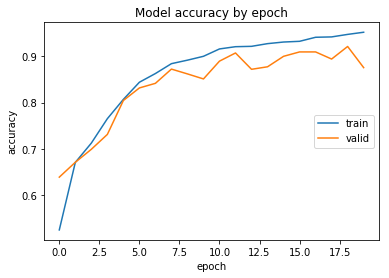

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()

There seems to be overfitting after around 10 epochs, so we will keep that value for now. Let us now look at the influence of the number of filters in the convolutional layers. This is a significant parameter since it is one of the two main parameters (with the kernel size) that creates the relevant features, used as input to the neuronal network. To do so, instead of doing a cross-validation which is costly for deep learning, it is needed to define a validation set, as a part of the training set. This is done hereafter.

In [90]:
from sklearn.model_selection import train_test_split

tx_train_only, tx_val, y_train_only_onehot, y_val_onehot = train_test_split(tx_train, y_train_onehot, test_size=0.3, random_state=1)


Now, we have obtained a smaller real training set (tx_train_only,y_train_only_onehot) to get a validation set (tx_val, y_val_onehot) on which it will be possible to compare the values of accuracy for different hyper-parameters.

In [22]:
filters = [8,16,32,64,128,256]

scores=[]

num_epochs = 10
kernel_size = 3

for num_filters in filters:
    
    print('TRAINING for', num_filters, 'filters\n')
    
    model = build_model(num_epochs,num_filters,kernel_size)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(tx_train_only, y_train_only_onehot, 
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1)

    # Evaluate the model on validation set set
    _,accuracy_val = model.evaluate(tx_val, y_val_onehot, verbose=0) 
    
    scores.append(accuracy_val)
    
    print('\n')

TRAINING for 8 filters

Epoch 1/10
5146/5146 [==============================] - 1s 243us/step - loss: 1.2657 - acc: 0.4118
Epoch 2/10
5146/5146 [==============================] - 1s 206us/step - loss: 0.8064 - acc: 0.5810
Epoch 3/10
5146/5146 [==============================] - 1s 171us/step - loss: 0.7014 - acc: 0.6327
Epoch 4/10
5146/5146 [==============================] - 1s 142us/step - loss: 0.6514 - acc: 0.6558
Epoch 5/10
5146/5146 [==============================] - 1s 137us/step - loss: 0.6164 - acc: 0.6759
Epoch 6/10
5146/5146 [==============================] - 1s 206us/step - loss: 0.5983 - acc: 0.6862
Epoch 7/10
5146/5146 [==============================] - 1s 172us/step - loss: 0.5764 - acc: 0.7003
Epoch 8/10
5146/5146 [==============================] - 1s 193us/step - loss: 0.5701 - acc: 0.7085
Epoch 9/10
5146/5146 [==============================] - 1s 131us/step - loss: 0.5466 - acc: 0.7241
Epoch 10/10
5146/5146 [==============================] - 1s 129us/step - loss: 0.5350

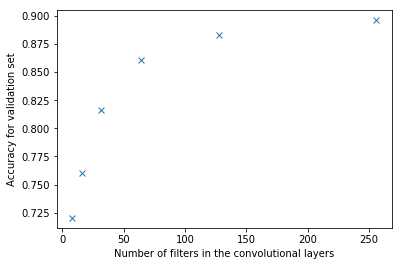

In [23]:
%matplotlib inline

plt.plot(filters, scores,'x')
plt.xlabel('Number of filters in the convolutional layers')
plt.ylabel('Accuracy for validation set')
plt.show()

We see that for 128 filters, we reach a good accuracy for all tested values of numbers of filters. For some numbers of filters higher than 128, it may be possible to do better but it would be way more costly ... Then, it is better to keep 128 filters and try to test other parameters. Let us now look at the influence of the kernel size in the convolutional layers, which also affects directly the significance of the learned features, used as input to the neuronal network.

In [91]:
kernels = [2,3,5,7,11]
scores=[]

num_epochs = 10
num_filters = 128

for kernel_size in kernels:
    print('TRAINING for the kernel size :', kernel_size,'\n')
    model = build_model(num_epochs,num_filters,kernel_size)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(tx_train_only, y_train_only_onehot, 
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1)

    # Evaluate the model on test set
    _,accuracy_val = model.evaluate(tx_val, y_val_onehot, verbose=0) 
    
    scores.append(accuracy_val)
    print('\n')

TRAINING for the kernel size : 2 

Epoch 1/10
5146/5146 [==============================] - 30s 6ms/step - loss: 0.9013 - acc: 0.5394
Epoch 2/10
5146/5146 [==============================] - 22s 4ms/step - loss: 0.5984 - acc: 0.6716
Epoch 3/10
5146/5146 [==============================] - 22s 4ms/step - loss: 0.5546 - acc: 0.7147
Epoch 4/10
5146/5146 [==============================] - 20s 4ms/step - loss: 0.5104 - acc: 0.7503
Epoch 5/10
5146/5146 [==============================] - 20s 4ms/step - loss: 0.4707 - acc: 0.7750
Epoch 6/10
5146/5146 [==============================] - 21s 4ms/step - loss: 0.4188 - acc: 0.8099
Epoch 7/10
5146/5146 [==============================] - 21s 4ms/step - loss: 0.3758 - acc: 0.8373
Epoch 8/10
5146/5146 [==============================] - 19s 4ms/step - loss: 0.3183 - acc: 0.8675
Epoch 9/10
5146/5146 [==============================] - 17s 3ms/step - loss: 0.3045 - acc: 0.8706
Epoch 10/10
5146/5146 [==============================] - 18s 3ms/step - loss: 0.248

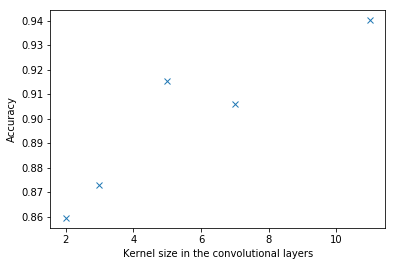

In [92]:
plt.plot(kernels, scores,'x')
plt.xlabel('Kernel size in the convolutional layers')
plt.ylabel('Accuracy')
plt.show()

We see that the best accuracy is obtained for a kernel size being equal to 11. We keep this value too in memory. Now, in order to see the influence of the number of epochs (and perhaps the overfitting), we run a final training for a sufficiently large number of epochs, in order to detect overfitting. The values used for some hyper-parameters (number of filters and kernel size) come from the previous discussion, in which we hope to have nearly tuned them. This discussion on the overfitting has been done before, but for other values of hyper-parameters. Rigourously, it needs to be done once again.

In [93]:
num_epochs = 20

#Tuned hyper-parameters
num_filters = 128
kernel_size = 11

model = build_model(num_epochs,num_filters,kernel_size)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(tx_train, y_train_onehot, 
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1,validation_split=0.3)


Train on 5146 samples, validate on 2206 samples
Epoch 1/20
5146/5146 [==============================] - 37s 7ms/step - loss: 0.8439 - acc: 0.5729 - val_loss: 0.6331 - val_acc: 0.6460
Epoch 2/20
5146/5146 [==============================] - 27s 5ms/step - loss: 0.5833 - acc: 0.6821 - val_loss: 0.5922 - val_acc: 0.6772
Epoch 3/20
5146/5146 [==============================] - 27s 5ms/step - loss: 0.5516 - acc: 0.7262 - val_loss: 0.5325 - val_acc: 0.7371
Epoch 4/20
5146/5146 [==============================] - 28s 5ms/step - loss: 0.4413 - acc: 0.8026 - val_loss: 0.4670 - val_acc: 0.8087
Epoch 5/20
5146/5146 [==============================] - 30s 6ms/step - loss: 0.3708 - acc: 0.8482 - val_loss: 0.3872 - val_acc: 0.8545
Epoch 6/20
5146/5146 [==============================] - 28s 5ms/step - loss: 0.2905 - acc: 0.8844 - val_loss: 0.3284 - val_acc: 0.8894
Epoch 7/20
5146/5146 [==============================] - 28s 5ms/step - loss: 0.2369 - acc: 0.9015 - val_loss: 0.3472 - val_acc: 0.8799
Epoch 8

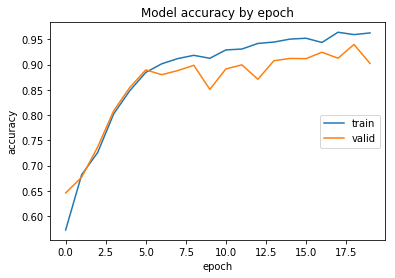

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()

We observe that there may be overfitting after around 8 epochs. Consequently, we finally train our model until that value.

In [95]:
num_epochs = 8

#Tuned hyper-parameters
num_filters = 128
kernel_size = 11

model = build_model(num_epochs,num_filters,kernel_size)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(tx_train, y_train_onehot, 
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1)


Epoch 1/8
7352/7352 [==============================] - 41s 6ms/step - loss: 0.7404 - acc: 0.6138
Epoch 2/8
7352/7352 [==============================] - 34s 5ms/step - loss: 0.5366 - acc: 0.7292
Epoch 3/8
7352/7352 [==============================] - 34s 5ms/step - loss: 0.3960 - acc: 0.8297
Epoch 4/8
7352/7352 [==============================] - 34s 5ms/step - loss: 0.2941 - acc: 0.8828
Epoch 5/8
7352/7352 [==============================] - 34s 5ms/step - loss: 0.2342 - acc: 0.9089
Epoch 6/8
7352/7352 [==============================] - 34s 5ms/step - loss: 0.2157 - acc: 0.9174
Epoch 7/8
7352/7352 [==============================] - 34s 5ms/step - loss: 0.1801 - acc: 0.9253
Epoch 8/8
7352/7352 [==============================] - 34s 5ms/step - loss: 0.1607 - acc: 0.9384


Now that the model has been correctly trained, we can have a look at the accuracy of the predictions on the test set.

In [96]:
# Evaluate the model on test set
print("\n EVALUATION [loss, accuracy] on TEST set:")
model.evaluate(tx_test, y_test_onehot, verbose=1) 


 EVALUATION [loss, accuracy] on TEST set:
2947/2947 [==============================] - 8s 3ms/step


[0.2851223230967141, 0.9172039362063115]

To have a better overview, the confusion matrix is computed hereafter.

In [97]:
from sklearn.metrics import confusion_matrix

y_true, y_pred = y_test, model.predict(tx_test)

#Converting the predicted classes into their original form
y_pred_int = []
for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        if y_pred[i][j] == max(y_pred[i]):
            y_pred_int.append(j+1)

print( confusion_matrix(y_true, y_pred_int) )


[[472   1  21   0   2   0]
 [  3 446  16   6   0   0]
 [  0   0 420   0   0   0]
 [  0   1   0 454  19  17]
 [  3   0   0  39 477  13]
 [  0   0   0  66  37 434]]


### Convnet 1D on all raw features

Then, it is possible to look at what changes if we add the total acceleration. The previous search for tuning the hyper-parameters is costly and it has already been done for the previous case. It will not be considered here, even though the same method could be applied. In this case, only arbitrary values for the hyper-parameters will be considered.

In [99]:
n_timesteps, n_features, n_outputs = tx_train_all.shape[1], tx_train_all.shape[2], y_train_onehot.shape[1]

num_epochs = 10
batch_size = 32

#Definition of the model 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(tx_train_all, y_train_onehot,
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1)

# EVvaluate the model on the test set
print("\n EVALUATION [loss, accuracy] on TEST set:")
model.evaluate(tx_test_all, y_test_onehot, verbose=0) 

Epoch 1/10
7352/7352 [==============================] - 22s 3ms/step - loss: 0.3777 - acc: 0.8489
Epoch 2/10
7352/7352 [==============================] - 15s 2ms/step - loss: 0.1447 - acc: 0.9421
Epoch 3/10
7352/7352 [==============================] - 15s 2ms/step - loss: 0.1166 - acc: 0.9493
Epoch 4/10
7352/7352 [==============================] - 15s 2ms/step - loss: 0.1175 - acc: 0.9517
Epoch 5/10
7352/7352 [==============================] - 15s 2ms/step - loss: 0.1175 - acc: 0.9516
Epoch 6/10
7352/7352 [==============================] - 15s 2ms/step - loss: 0.0950 - acc: 0.9569
Epoch 7/10
7352/7352 [==============================] - 16s 2ms/step - loss: 0.1019 - acc: 0.9565
Epoch 8/10
7352/7352 [==============================] - 16s 2ms/step - loss: 0.1057 - acc: 0.9561
Epoch 9/10
7352/7352 [==============================] - 16s 2ms/step - loss: 0.0857 - acc: 0.9596
Epoch 10/10
7352/7352 [==============================] - 16s 2ms/step - loss: 0.0758 - acc: 0.9667

 EVALUATION [loss,

[0.32217892559455946, 0.9205972175093315]

We observe that we get a better accuracy using all 3D raw features with arbitrary hyper-parameters than with only two. To improve this result, it would be possible to tune the hyper-parameters as it has been done in the latter subsection. Take a look at the confusion matrix.

In [100]:
from sklearn.metrics import confusion_matrix

y_true, y_pred = y_test, model.predict(tx_test_all)

#Converting the predicted classes into their original form
y_pred_int = []
for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        if y_pred[i][j] == max(y_pred[i]):
            y_pred_int.append(j+1)

print( confusion_matrix(y_true, y_pred_int) )

[[453   5  38   0   0   0]
 [  2 443  26   0   0   0]
 [  1   0 419   0   0   0]
 [  1  17   0 393  75   5]
 [  4   2   0  58 468   0]
 [  0   0   0   0   0 537]]


In conclusion, our final accuracy (of around 0.92) appears very close to the best accuracy of our first part: classification on pre-processed data (accuracy of 0.95 thanks to random forest). This is quite impressive !

## 2- Hidden Markov Model

Use to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/index.html) library.

Training of one particular Gaussian HMM for each class (i.e. for each gesture).

In [14]:
from hmmlearn import hmm

x_train = merged_data_train

place = np.where(y_train == 1)[0]
lengths = [128 for j in range(place.shape[0])]
X_train = x_train[place].reshape(-1,1)

model1 = hmm.GaussianHMM(n_components=9, algorithm='viterbi')
model1.fit(X_train, lengths)  

place = np.where(y_train == 2)[0]
lengths = [128 for j in range(place.shape[0])]
X_train = x_train[place].reshape(-1,1)

model2 = hmm.GaussianHMM(n_components=9, algorithm='viterbi')
model2.fit(X_train, lengths)  

place = np.where(y_train == 3)[0]
lengths = [128 for j in range(place.shape[0])]
X_train = x_train[place].reshape(-1,1)

model3 = hmm.GaussianHMM(n_components=9, algorithm='viterbi')
model3.fit(X_train, lengths)  

place = np.where(y_train == 4)[0]
lengths = [128 for j in range(place.shape[0])]
X_train = x_train[place].reshape(-1,1)

model4 = hmm.GaussianHMM(n_components=9, algorithm='viterbi')
model4.fit(X_train, lengths)  

place = np.where(y_train == 5)[0]
lengths = [128 for j in range(place.shape[0])]
X_train = x_train[place].reshape(-1,1)

model5 = hmm.GaussianHMM(n_components=9, algorithm='viterbi')
model5.fit(X_train, lengths)  

place = np.where(y_train == 6)[0]
lengths = [128 for j in range(place.shape[0])]
X_train = x_train[place].reshape(-1,1)

model6 = hmm.GaussianHMM(n_components=9, algorithm='viterbi')
model6.fit(X_train, lengths)  


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=9, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

We compute the log probability of each example under each model (thanks to the score() method), and the model with the higher log-probability is assumed to be the one trained on the good class:  we pick the HMM with the maximum likelihood.


In [15]:
x_test = merged_data_test

good_answers = 0
y_pred = [0 for j in range(y_test.shape[0])]

for i in range(y_test.shape[0]):
    test = [model1.score((x_test[i].reshape(-1, 1))),model2.score((x_test[i].reshape(-1, 1))),
     model3.score((x_test[i].reshape(-1, 1))),model4.score((x_test[i].reshape(-1, 1))),
     model5.score((x_test[i].reshape(-1, 1))),model6.score((x_test[i].reshape(-1, 1)))]

    y_pred[i] = test.index(max(test))+1
    
    if(y_pred[i] == y_test[i]):
        good_answers += 1
        
averrage = good_answers / y_test.shape[0]

print("Averrage accuracy:", averrage)

print("\n CONFUSION MATRIX")
print( confusion_matrix(y_test, y_pred) )


Averrage accuracy: 0.6274177129284018

 CONFUSION MATRIX
[[371  72  53   0   0   0]
 [ 96 335  40   0   0   0]
 [ 46  80 294   0   0   0]
 [  0  17   0 278 128  68]
 [  1   7   0 100 424   0]
 [  0  52   0 270  68 147]]


(as usual, we clearly see the more "confusion" (wrong classification) inside the two main "clusters" of our data: the classes 1, 2 and 3 together, the classes 4, 5 and 6 together)

The resulting accuracy is not that bad for Hidden Markov Models with this small number of states (only 9). Though, the accuracy is far from the one of the convolutional neural network. This can be explained by different reasons: the fact that we only use a mean of the 3 axis as our input temporal series (and only the acceleration series, not the gyroscope one), or the fact that we didn't set up our HMM to be a a proper left-righ HMM, which would have been more adapted (we tried, though, and it didn't work that well...).
Implementing the HMM in 3 dimensions would have taken a lot of extra time.